In [1]:
import pandas as pd 
import itertools
from tqdm import tqdm
from pandas.tseries.offsets import Week
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.utilities import regressor_coefficients
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns


pd.options.display.float_format = '{:.4f}'.format
%matplotlib inline
%%capture

Importing plotly failed. Interactive plots will not work.
UsageError: Line magic function `%%capture` not found.


In [2]:
def print_metrics(future, forecast):
    # I don't consider this clean, but time is of the essence 
    print(f"MSE: {round(mean_squared_error(future['y'], forecast['yhat']), 3)}")
    print(f"MAPE: {round(mean_absolute_percentage_error(future['y'], forecast['yhat']), 3)}")
    print(f"MAE: {round(mean_absolute_error(future['y'], forecast['yhat']), 3)}")
    print(f"R^2: {round(r2_score(future['y'], forecast['yhat']), 3)}")

In [3]:
def plot_predicted_vs_actual(forecast, future):
    fig, ax = plt.subplots(figsize=(12,7))

    ax.fill_between(
        x=forecast['ds'],
        y1=forecast['yhat_lower'],
        y2=forecast['yhat_upper'],
        alpha=0.25,
        label=r'0.95 credible_interval'
    )

    sns.lineplot(x='ds', y='y', label='actual', data=future, ax=ax)
    sns.lineplot(x='ds', y='yhat', label='predicted', data=forecast, ax=ax)
    ax.legend(loc='lower right')
    ax.set(title='Dependent Variable', ylabel='');
    plt.show()

In [4]:
def get_model_forecast(df_train, df_test, regressors, propeth_hparams={}):
    
    if bool(propeth_hparams):
        m = Prophet()
    else:
        m = Prophet(**propeth_hparams)
    
    for reg in regressors:
        m.add_regressor(reg)

    m.add_country_holidays(country_name='US')
    
    m.fit(df_train)  
    forecast = m.predict(df_test)
    
    return (m, forecast)

# Loading Taxi Ride Data

In [5]:
df_rides = pd.read_pickle('../data/full_cleaned_trip_data.pkl')

In [6]:
df_rides['ds'] = df_rides['tpep_pickup_datetime'].dt.date

# Aggregating the data for prophet

## Daily transactions

In [7]:
daily_agg_data = df_rides.groupby(['ds']).agg(y=('tpep_pickup_datetime', 'count')).reset_index()

<AxesSubplot:xlabel='ds'>

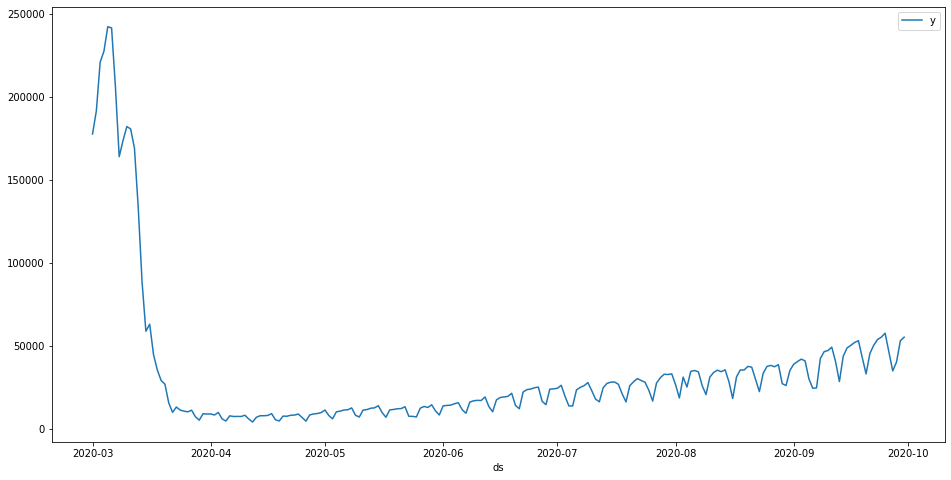

In [8]:
daily_agg_data.plot(x='ds', y='y', figsize=(16,8))

# Weekly transactions

In [9]:
daily_agg_data['ds_w'] = daily_agg_data['ds'].apply(lambda x: x if x.weekday() == 6 else x + Week(weekday=6))

In [10]:
weekly_agg_data = daily_agg_data.groupby(['ds_w']).agg(y=('y', 'sum')).reset_index()

In [11]:
df_weekly = weekly_agg_data.rename(columns={'ds_w':'ds'})

<AxesSubplot:xlabel='ds_w'>

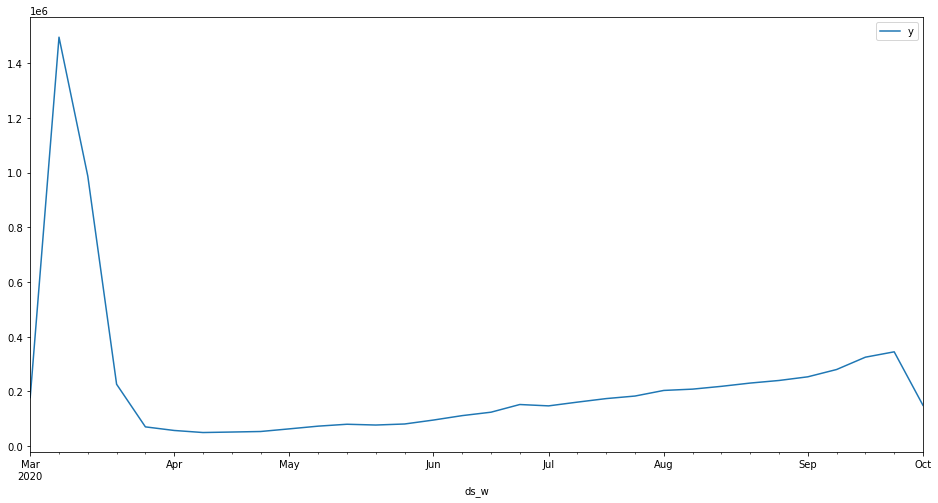

In [12]:
weekly_agg_data.plot(x='ds_w', y='y', figsize=(16,8))

# Add External Data

##### Daily

In [13]:
df_covid = pd.read_pickle('../data/covid_daily_processed.pkl')
df_weather = pd.read_pickle('../data/aggregated_daily_weather_data.pkl')
df_reg = pd.read_pickle('../data/reg_daily.pkl')
df_mobility = pd.read_pickle('../data/mobility.pkl')
df_daily = daily_agg_data.merge(df_covid).merge(df_weather).merge(df_reg).merge(df_mobility)

In [14]:
df_daily.corr()['y']

y                       1.0000
CASE_COUNT_7DAY_AVG    -0.3540
prcp_avg               -0.0494
tmax_avg               -0.2087
regulation_status       0.6856
retail_mobility         0.5873
workplaces_mobility     0.6050
transit_mobility        0.6229
residential_mobility   -0.5055
grocery_mobility        0.3040
Name: y, dtype: float64

# Adding 'Lag' to Covid and Mobility Data

In [15]:
df_daily['CASE_COUNT_7DAY_AVG'] = df_daily['CASE_COUNT_7DAY_AVG'].shift(30, fill_value=0)

In [16]:
df_daily['workplaces_mobility'] = df_daily['workplaces_mobility'].shift(30, fill_value=0)
df_daily['transit_mobility'] = df_daily['transit_mobility'].shift(30, fill_value=0)
df_daily['retail_mobility'] = df_daily['retail_mobility'].shift(30, fill_value=0)
df_daily['grocery_mobility'] = df_daily['grocery_mobility'].shift(30, fill_value=0)
df_daily['residential_mobility'] = df_daily['residential_mobility'].shift(30, fill_value=0)


# Separate "Future" September Data for Forecast 

In [17]:
future_daily = df_daily[df_daily['ds'] >= pd.to_datetime('2020-09-01')]

In [18]:
df_daily_history = df_daily[df_daily['ds'] < pd.to_datetime('2020-09-01')]

In [19]:
future_weekly = df_weekly[df_weekly['ds'] >= pd.to_datetime('2020-09-01')]

In [20]:
df_weekly_history = df_weekly[df_weekly['ds'] < pd.to_datetime('2020-09-01')]

# Baseline 

### Daily Forecast

In [21]:
m = Prophet()
m.fit(df_daily_history[['ds', 'y']])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
forecast = m.predict(future_daily)

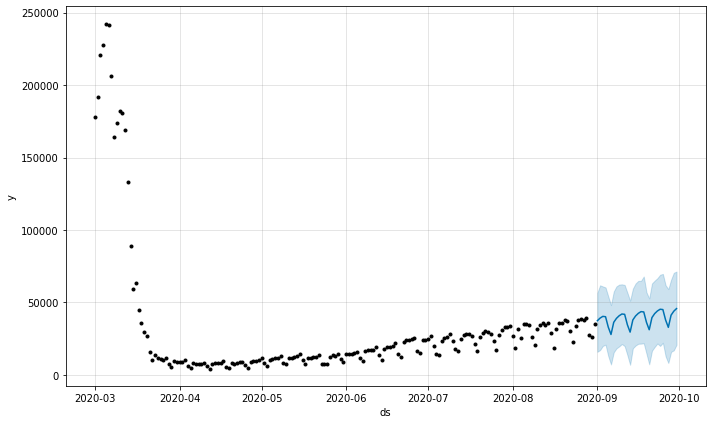

In [23]:
fig1 = m.plot(forecast)

In [24]:
print_metrics(future_daily, forecast)

MSE: 48604084.259
MAPE: 0.134
MAE: 6024.009
R^2: 0.388


### Weekly

In [25]:
m = Prophet()
m.fit(df_weekly_history[['ds', 'y']])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


In [26]:
forecast_weekly = m.predict(future_weekly)

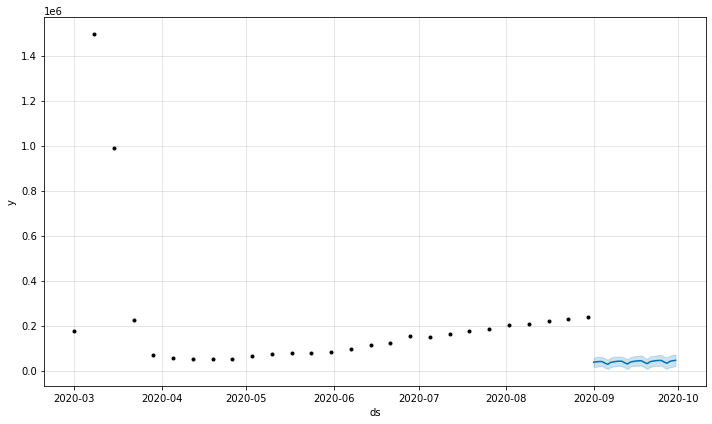

In [27]:
fig1 = m.plot(forecast)

In [28]:
print_metrics(future_weekly, forecast_weekly)

MSE: 58812412855.916
MAPE: 0.86
MAE: 233402.689
R^2: -11.437


# With External Data

In [29]:
regressors = [
#     'prcp_avg',
# #     'tmax_avg',
    'retail_mobility',
    'residential_mobility',
#     'grocery_mobility', 
    'transit_mobility',
#     'workplaces_mobility',
    'CASE_COUNT_7DAY_AVG',
#     'regulation_status'
]


### Forecast for August

In [30]:
df_history = df_daily_history[df_daily_history['ds'] < pd.to_datetime('2020-08-01')]
df_future = df_daily_history[df_daily_history['ds'] >= pd.to_datetime('2020-08-01')]

In [31]:
m, forecast_aug = get_model_forecast(df_history, df_future, regressors)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


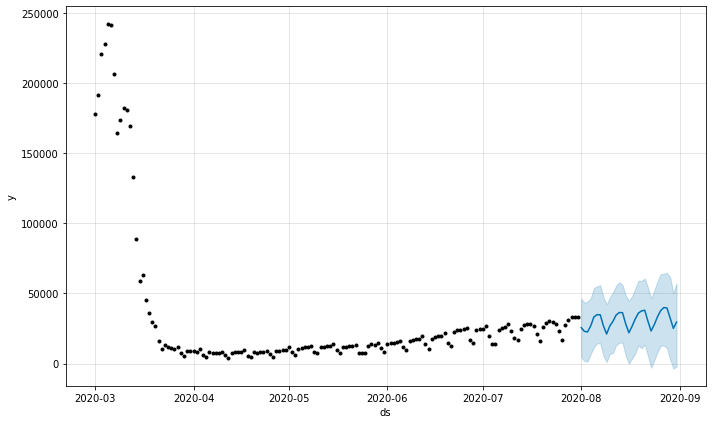

In [32]:
fig1 = m.plot(forecast_aug)

In [33]:
print_metrics(df_future, forecast_aug)

MSE: 10285397.39
MAPE: 0.077
MAE: 2313.334
R^2: 0.699


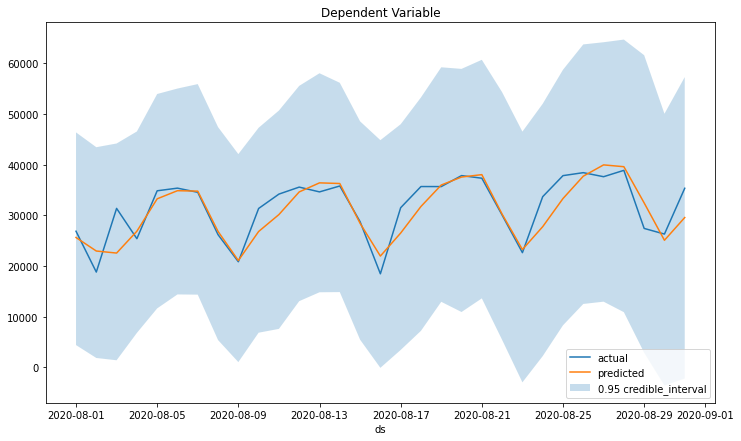

In [34]:
plot_predicted_vs_actual(forecast_aug, df_future)

### Forecast for September

In [35]:
m, forecast_sep = get_model_forecast(df_daily_history, future_daily, regressors)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
print_metrics(future_daily, forecast_sep)

MSE: 26284836.473
MAPE: 0.107
MAE: 4039.23
R^2: 0.669


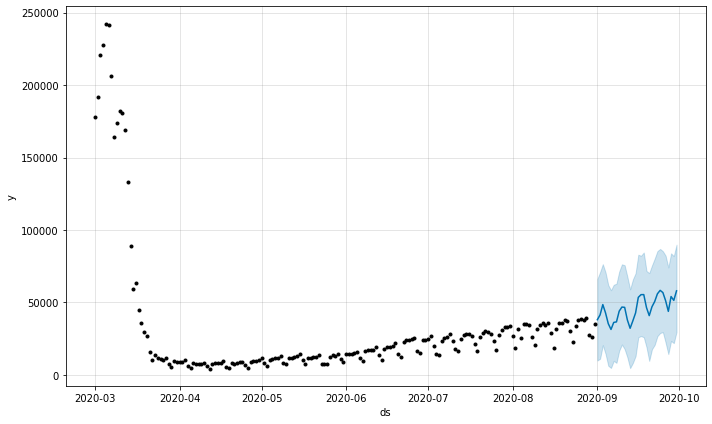

In [37]:
fig1 = m.plot(forecast_sep)

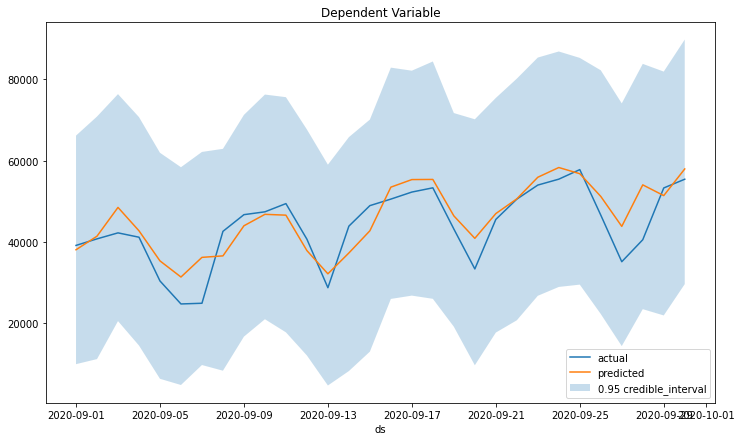

In [38]:
plot_predicted_vs_actual(forecast_sep, future_daily)

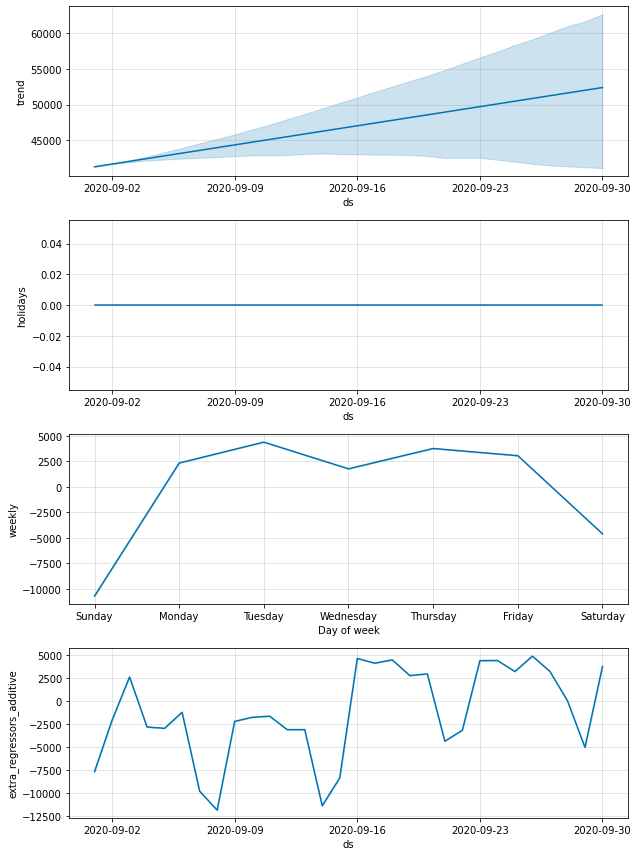

In [58]:
fig1 = m.plot_components(forecast_sep)

In [59]:
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,retail_mobility,additive,-19.3284,32.9753,32.9753,32.9753
1,residential_mobility,additive,9.5310,465.3349,465.3349,465.3349
2,transit_mobility,additive,-24.4670,-391.1485,-391.1485,-391.1485
3,CASE_COUNT_7DAY_AVG,additive,1211.7011,-0.1778,-0.1778,-0.1778


# Aggregate Forecasts on weekly level

In [40]:
forecast_sep['ds_w'] = forecast_sep['ds'].apply(lambda x: x if x.weekday() == 6 else x + Week(weekday=6))
future_daily['ds_w'] = future_daily['ds'].apply(lambda x: x if x.weekday() == 6 else x + Week(weekday=6))

/home/svujovic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
forecast_sep_weekly = forecast_sep.groupby('ds_w').agg(yhat=('yhat','sum'), yhat_lower=('yhat_lower', 'sum'), yhat_upper=('yhat_upper', 'sum')).reset_index()
future_weekly = future_daily.groupby('ds_w').agg(y=('y','sum')).reset_index()
forecast_sep_weekly = forecast_sep_weekly.rename(columns={'ds_w': 'ds'})
future_weekly = future_weekly.rename(columns={'ds_w': 'ds'})

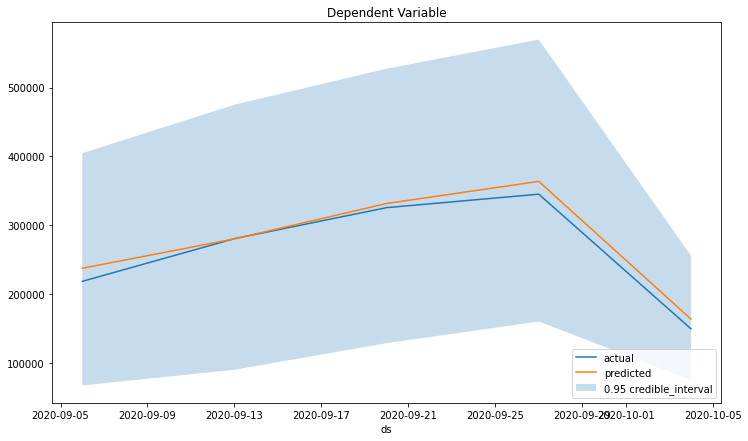

In [55]:
plot_predicted_vs_actual(forecast_sep_weekly, future_weekly)

In [57]:
print_metrics(future_weekly, forecast_sep_weekly)

MSE: 189078036.761
MAPE: 0.051
MAE: 11635.339
R^2: 0.963
